# Libraries

In [2]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import re


Utilities

In [27]:
from datetime import datetime
import matplotlib.pyplot as plt

def get_current_datetime():
    current_date = datetime.now().strftime("%B %d, %Y")
    current_time = datetime.now().strftime("%I:%M %p")

    return current_date, current_time

def print_current_datetime():
    date, time = get_current_datetime()
    print(f'({date} | {time})')
    

def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, 'bo', label='Training Loss')
    plt.plot(epochs, val_losses, 'r', label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Dataset

In [57]:
raw_dataset = {
    'train': pd.read_csv('../new-dataset/train_data.csv').reset_index(drop=True),  #  encoding='cp1252' insert between train_data.csv and .reset index as parameter
    'test': pd.read_csv('../new-dataset/test_data.csv').reset_index(drop=True),
    'val': pd.read_csv('../new-dataset/val_data.csv').reset_index(drop=True)
}

LABELS = ['Age', 'Gender', 'Physical', 'Race', 'Religion', 'Others']

class MLTHSDataset(Dataset):
    def __init__(self, data, tokenizer, labels, max_token_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.labels = labels
        self.max_token_len = max_token_len
        self.encoded_dataset = self.encode_dataset()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.encoded_dataset[index]
    
    def preprocess(text_column):
        
        text_column = text_column.apply(lambda x: re.sub(r'[A-Z]', lambda y: y.group(0).lower(), x))
        # Removal of unimportant links
        text_column = text_column.apply(lambda x: re.sub(r'http[s]?://\S+', '', x))

        # emoji 
        text_column = text_column.apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

        # username
        text_column = text_column.apply(lambda x: re.sub(r'@\w+', '', x))

        # punctuations
        text_column = text_column.apply(lambda x: re.sub(r'[^\w\s]', ' ', x))

        # hashtag
        text_column = text_column.apply(lambda x: re.sub(r'#', '', x))
        
        return text_column

    def encode_dataset(self):
        encoded_dataset = []
        for index, data in tqdm(self.data.iterrows()):
            encoded_data = self.encode_data(data)
            encoded_dataset.append(encoded_data)
        return encoded_dataset

    def encode_data(self, data):
        text = data["Text"]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            return_tensors='pt',
            padding='max_length',
            truncation=True,
            max_length=128,
            return_token_type_ids=False,
            return_attention_mask=True
        )
        labels = [data[label] for label in self.labels]

        representation = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(labels)
        }
        return representation

class MLTHSDataLoader:
    def __init__(self, dataset, labels, tokenizer, batch_size=8):
        self.train_dataset = MLTHSDataset(dataset['train'], tokenizer, labels)
        self.val_dataset = MLTHSDataset(dataset['val'], tokenizer, labels)
        self.test_dataset = MLTHSDataset(dataset['test'], tokenizer, labels)
        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=0, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=0, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=0, shuffle=False)

Preprocessor

In [44]:
def preprocess(text_column):

    text_column = text_column.apply(lambda x: re.sub(r'[A-Z]', lambda y: y.group(0).lower(), x))
    # Removal of unimportant links
    text_column = text_column.apply(lambda x: re.sub(r'http[s]?://\S+', '', x))

    # emoji 
    text_column = text_column.apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

    # username
    text_column = text_column.apply(lambda x: re.sub(r'@\w+', '', x))

    # punctuations
    text_column = text_column.apply(lambda x: re.sub(r'[^\w\s]', ' ', x))

    # hashtag
    text_column = text_column.apply(lambda x: re.sub(r'#', '', x))
    
    return text_column

In [4]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, BertModel, get_cosine_schedule_with_warmup

tokenizer = BertTokenizer.from_pretrained('gklmip/bert-tagalog-base-uncased')
model_name = "gklmip/bert-tagalog-base-uncased"
LABELS = ['Age', 'Gender', 'Physical', 'Race', 'Religion', 'Others']



d:\Repo\Thesis\BERT-MLTHSC\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DataLoader

In [5]:
dataloader = MLTHSDataLoader(dataset=raw_dataset, tokenizer=tokenizer, labels=LABELS)

def split_dataloader(dataloader):
    train_dataloader = dataloader.train_dataloader()
    val_dataloader = dataloader.val_dataloader()
    test_dataloader = dataloader.test_dataloader()

    return train_dataloader, val_dataloader, test_dataloader

train_dataloader, val_dataloader, test_dataloader = split_dataloader(dataloader)

0it [00:00, ?it/s]

1260it [00:01, 885.09it/s] 
210it [00:00, 1740.17it/s]
630it [00:00, 1666.72it/s]


Class Weights
- dahil imbalanced ang dataset, gagamitin natin eto para ibalance ang loss

In [6]:
def get_class_weights(num_labels, dataloader):
    class_counts = torch.zeros(num_labels)
    for batch in dataloader:
        labels = batch['labels']
        class_counts += labels.sum(dim=0)

    # Calculate class weights
    total_samples = class_counts.sum()
    class_weights = total_samples / (num_labels * class_counts)

    # Normalize weights so that the sum is equal to the number of classes
    class_weights /= class_weights.sum()

    print("Class Weights:", class_weights)

    return class_weights

num_labels = len(LABELS)
class_weights = get_class_weights(num_labels, train_dataloader)

Class Weights: tensor([0.1733, 0.1538, 0.1304, 0.1598, 0.1919, 0.1910])


# Model


In [7]:
class HateSpeechClassifier(nn.Module):
    def __init__(self, model_name, num_labels, batch_size=8,epochs=5): 
        super(HateSpeechClassifier, self).__init__()
        self.bert_model = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(self.bert_model.config.hidden_size, num_labels)
        self.batch_size = batch_size
        self.epochs = epochs
        self.criterion = nn.BCEWithLogitsLoss(reduction='mean', weight=class_weights)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=2e-5, weight_decay=0.01) 
        self.scheduler = get_cosine_schedule_with_warmup(self.optimizer, 
                                                    num_warmup_steps=0,
                                                    num_training_steps= int(dataloader.train_dataset.__len__() / batch_size + 1))

        for param in self.bert_model.parameters():
            param.requires_grad = True

    def forward(self, ids, mask):
        bert_outputs = self.bert_model(ids, attention_mask=mask)
        cls_hidden_state = bert_outputs.last_hidden_state[:, 0, :] 
        dropped_out = self.dropout(cls_hidden_state)
        logits = self.linear(dropped_out)
        return logits
    
    def train(self, model, epochs=5, max_batches=None, save_file_name="trained_model", save_model=True):

        log_interval = 32
        early_stop_patience=2
        best_val_loss = float('inf')
        no_improvement_count = 0

        epoch_list = []
        train_losses = []
        val_losses = []
        val_metrics_history = []

        print_current_datetime()  # 1260 train data / batch size = 8 = 156 batches

        for epoch_idx in tqdm(range(1, epochs+1), desc=f"Epoch"):

            print(f"Running epoch {epoch_idx}")
            print_current_datetime()

            model.train()
            train_loss = 0.0

            for batch_idx, batch in enumerate(train_dataloader):

                if max_batches is not None and batch_idx >= max_batches:
                    break
                
                input_ids = batch['input_ids']
                attention_mask = batch['attention_mask']
                labels = batch['labels']

                # forward pass
                outputs = model(input_ids, attention_mask)
                loss = self.loss_fn(outputs, labels)
                
                # log loss every n batches cause why not
                if batch_idx % log_interval == 0:
                    print(f"Epoch {epoch_idx}, Batch {batch_idx}, Loss: {loss.item()}")

                # backpropagation
                self.optimizer.zero_grad(set_to_none=True)
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                # gradient descent (update the model's parameters)
                self.optimizer.step()

                # reduce learning rate
                self.scheduler.step()

                total_loss += loss.item()

            average_train_loss = train_loss / len(train_dataloader)

            print(f"Epoch {epoch_idx}, Average Loss: {average_train_loss}")
            print_current_datetime()

            # Evaluate using validation set, dito natin malalaman kung nag-iimprove ang model
            # Ineexpect natin na dapat bumaba ang loss for each epoch 
            val_loss, val_metrics = eval_model(model, val_dataloader)
            print(f"Validation Loss: {val_loss}")
            print("Validation Metrics:", val_metrics)

            # Graph losses so far for each epoch
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            plot_losses(train_losses, val_losses)

            # Graph metrices so far for each epoch
            plot_losses(epoch=epoch_list, metrics=val_metrics_history)

            # Tandaan, mas maganda ang lesser validation loss, kaya yan isesave natin
            if val_loss < best_val_loss:
                best_val_loss = val_loss

                if save_model:
                    current_datetime = datetime.now().strftime("(%m-%d-%Y)_(%I-%M-%S-%p)")
                    current_date = datetime.now().strftime("%B %d, %Y")
                    save_dir = os.path.join("../saved_models", current_date)
                    os.makedirs(save_dir, exist_ok=True)
                    file_name = f"trained_model-{current_datetime}.pth"
                    model_save_path = os.path.join(save_dir, file_name)
                    torch.save(model.state_dict(), model_save_path)

                print("Saved the best model!")
                
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            # Early stoping - tigil training kapag di na nag-improve ang validation loss after certain number of epoch (3)
            if no_improvement_count >= early_stop_patience:
                print(f"No improvement for {early_stop_patience} epochs. Stopping early.")
                break
        
        print("Training complete. Happy hacking I guess...")
        print("Model is ready for evaluation")

        return model
    
    
    def loss_fn(self, outputs, targets):
        return self.criterion(outputs, targets)

    

Setup the classifier 

In [14]:
hsclassifier = HateSpeechClassifier(model_name, len(LABELS))
hsclassifier

Some weights of BertModel were not initialized from the model checkpoint at gklmip/bert-tagalog-base-uncased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


HateSpeechClassifier(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(52099, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

# Metrics

- dito ay kukunin natin ang confusion matrix sa bawat labels para makuha ang TP, TN, FP, FN
- gagamitin din natin to para makuha ang most frequent errors
- ginamit yung formula ng precisionl, recall, f-measure para makuha prf per label
- xor method to calculate hamming loss

In [8]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

def calculate_metrics(confusion_matrix):
    TP = confusion_matrix[1, 1]  # True Positives
    FP = confusion_matrix[0, 1]  # False Positives
    FN = confusion_matrix[1, 0]  # False Negatives
    TN = confusion_matrix[0, 0]  # True Negatives

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return {
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score
    }

def hamming_loss(y_true, y_pred):
    xor_result = np.logical_xor(y_true, y_pred)
    xor_sum = np.sum(xor_result)
    hamming_loss = xor_sum / (y_true.shape[0] * y_true.shape[1])
    return hamming_loss

def multilabel_metrics(predictions, labels, mode="validation", threshold=0.5):
    sigmoid = torch.nn.Sigmoid()
    probabilities = sigmoid(torch.Tensor(predictions))

    y_pred = np.zeros(probabilities.shape)
    y_pred[np.where(probabilities >= threshold)] = 1

    y_true = np.zeros(labels.shape)
    y_true[np.where(labels == 1)] = 1

    confusion_matrix = multilabel_confusion_matrix(y_true, y_pred)

    print("Confusion Matrix")
    print(confusion_matrix)

    label_metrics = {}
    classes = ['Age', 'Gender', 'Physical', 'Race', 'Religion', 'Others']

    for i, class_name in enumerate(classes):
        metrics = calculate_metrics(confusion_matrix[i])
        label_metrics[class_name] = metrics

        precision = metrics['Precision'] * 100
        recall = metrics['Recall'] * 100
        f1 = metrics['F1-Score'] * 100

        print(f"{class_name}")
        print(f"    Precision: {precision:.2f}%")
        print(f"    Recall: {recall:.2f}%")
        print(f"    F-Measure: {f1:.2f}%")

    label_metrics['hamming_loss'] = hamming_loss(y_true, y_pred)
    print(f"\nHamming Loss ({mode}): {label_metrics['hamming_loss']}")

    return label_metrics

def plot_metrics(metrics, epochs):
    metrics_names = list(metrics['Age'].keys())[:-1]  # Exclude 'hamming_loss'
    classes = list(metrics.keys())
    
    for metric_name in metrics_names:
        for class_name in classes:
            plt.plot(epochs, [metrics[class_name][metric_name]] * len(epochs), label=f"{class_name} {metric_name}")
    
    plt.title(f"{metric_name} over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

# Training

### Hyperparameters

Ang purpose ng loss function ay para icalculate ang difference between models' prediction and true labels/targets

Ang loss ay something na gusto nating mabawasan sa pamamagitan ng pagtetrain ng model, ito ay ibabackpropagate natin where icacalculate ang gradient of loss ng bawat model's parameters

Optimizer naman ang gagamitin natin to actually update the model's parameters 

In [9]:


batch_size = 8
epochs = 5
criterion = nn.BCEWithLogitsLoss(reduction='mean', weight=class_weights)

def loss_fn(outputs, targets):
    return criterion(outputs, targets)

# configure optimizer
optimizer = torch.optim.Adam(hsclassifier.parameters(), lr=2e-5, weight_decay=0.01) 
scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps= int(dataloader.train_dataset.__len__() / batch_size + 1))

print(criterion)
print(optimizer)

NameError: name 'hsclassifier' is not defined

In [34]:
def eval_model(model, val_dataloader, mode="validation"):

    model.eval()

    val_loss = 0.0
    predictions = []
    labels_list  = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            
            val_input_ids = batch['input_ids']
            val_attention_mask = batch['attention_mask']
            val_labels = batch['labels']

            outputs = model(val_input_ids, val_attention_mask)

            if mode == "validation":
                loss = criterion(outputs, val_labels)
                val_loss += loss.item()

            predictions.append(outputs.cpu().numpy())
            labels_list.append(val_labels.cpu().numpy())

    predictions = np.vstack(predictions)
    labels = np.vstack(labels_list)  
    metrics = multilabel_metrics(predictions=predictions, labels=labels, threshold=0.5)

    average_val_loss = val_loss / len(val_dataloader)
    return average_val_loss, metrics

In [1]:
"""

Training Loop

1. Forward pass
2. Calculate Loss
3. Backpropagation 
4. Update model paramters (gradient descent)

"""

def train_model(model, epochs=5, max_batches=None, save_file_name="trained_model", save_model=True):

    log_interval = 32
    early_stop_patience=2
    best_val_loss = float('inf')
    no_improvement_count = 0

    epoch_list = []
    train_losses = []
    val_losses = []
    val_metrics_history = []

    print_current_datetime()  # 1260 train data / batch size = 8 = 156 batches

    for epoch_idx in tqdm(range(1, epochs+1), desc=f"Epoch"):

        print(f"Running epoch {epoch_idx}")
        print_current_datetime()

        model.train()
        train_loss = 0.0

        for batch_idx, batch in enumerate(train_dataloader):

            if max_batches is not None and batch_idx >= max_batches:
                break
            
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            # forward pass
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            
            # log loss every n batches cause why not
            if batch_idx % log_interval == 0:
                print(f"Epoch {epoch_idx}, Batch {batch_idx}, Loss: {loss.item()}")

            # backpropagation
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # gradient descent (update the model's parameters)
            optimizer.step()

            # reduce learning rate
            scheduler.step()

            total_loss += loss.item()

        average_train_loss = train_loss / len(train_dataloader)

        print(f"Epoch {epoch_idx}, Average Loss: {average_train_loss}")
        print_current_datetime()

        # Evaluate using validation set, dito natin malalaman kung nag-iimprove ang model
        # Ineexpect natin na dapat bumaba ang loss for each epoch 
        val_loss, val_metrics = eval_model(model, val_dataloader)
        print(f"Validation Loss: {val_loss}")
        print("Validation Metrics:", val_metrics)

        # Graph losses so far for each epoch
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        plot_losses(train_losses, val_losses)

        # Graph metrices so far for each epoch
        plot_losses(epoch=epoch_list, metrics=val_metrics_history)

        # Tandaan, mas maganda ang lesser validation loss, kaya yan isesave natin
        if val_loss < best_val_loss:
            best_val_loss = val_loss

            if save_model:
                current_datetime = datetime.now().strftime("(%m-%d-%Y)_(%I-%M-%S-%p)")
                current_date = datetime.now().strftime("%B %d, %Y")
                save_dir = os.path.join("../saved_models", current_date)
                os.makedirs(save_dir, exist_ok=True)
                file_name = f"trained_model-{current_datetime}.pth"
                model_save_path = os.path.join(save_dir, file_name)
                torch.save(model.state_dict(), model_save_path)

            print("Saved the best model!")
            
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        # Early stoping - tigil training kapag di na nag-improve ang validation loss after certain number of epoch (3)
        if no_improvement_count >= early_stop_patience:
            print(f"No improvement for {early_stop_patience} epochs. Stopping early.")
            break
    
    print("Training complete. Happy hacking I guess...")
    print("Model is ready for evaluation")

    return model


### Start Training

default values: 
    
    - max_batches = 0
    - epochs = 5

(November 18, 2023 | 09:28 AM)


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running epoch 1
(November 18, 2023 | 09:28 AM)
Epoch 1, Batch 0, Loss: 0.1108107641339302
Epoch 1, Average Loss: 0.0021301829079283944
(November 18, 2023 | 09:28 AM)


100%|██████████| 27/27 [00:33<00:00,  1.24s/it]


Confusion Matrix
[[[155  24]
  [ 27   4]]

 [[166   1]
  [ 43   0]]

 [[138   6]
  [ 66   0]]

 [[140  32]
  [ 22  16]]

 [[138  27]
  [ 31  14]]

 [[170   7]
  [ 32   1]]]
Age
    Precision: 14.29%
    Recall: 12.90%
    F-Measure: 13.56%
Gender
    Precision: 0.00%
    Recall: 0.00%
    F-Measure: 0.00%
Physical
    Precision: 0.00%
    Recall: 0.00%
    F-Measure: 0.00%
Race
    Precision: 33.33%
    Recall: 42.11%
    F-Measure: 37.21%
Religion
    Precision: 34.15%
    Recall: 31.11%
    F-Measure: 32.56%
Others
    Precision: 12.50%
    Recall: 3.03%
    F-Measure: 4.88%

Hamming Loss (validation): 0.2523809523809524
Validation Loss: 0.10158716804451412
Validation Metrics: {'Age': {'Precision': 0.14285714285714285, 'Recall': 0.12903225806451613, 'F1-Score': 0.13559322033898305}, 'Gender': {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0}, 'Physical': {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0}, 'Race': {'Precision': 0.3333333333333333, 'Recall': 0.42105263157894735, 'F1-Score

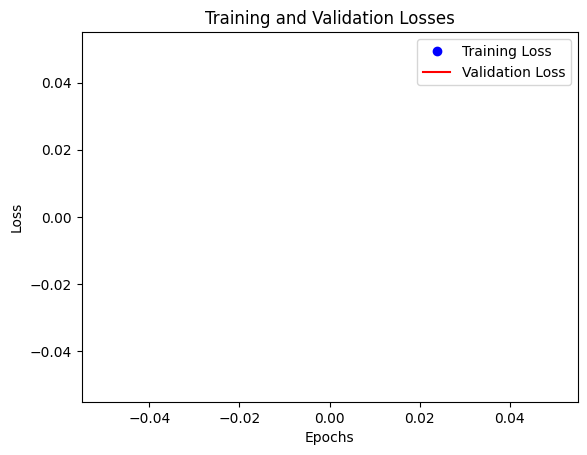

Epoch:   0%|          | 0/1 [00:47<?, ?it/s]


IndexError: invalid index to scalar variable.

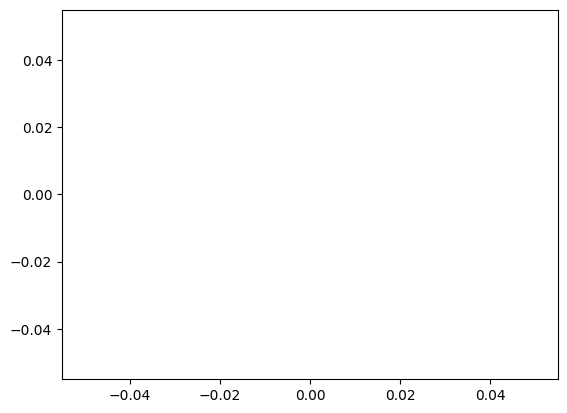

In [38]:
def debug_training(debug=False):

    if debug:
        max_batches = 3 
        epochs = 1
    else:
        max_batches = 0 
        epochs = 5
    return epochs, max_batches 

trained_model = train_model(hsclassifier,  max_batches=3 , epochs=1, save_model=False)

# Inference

In [10]:
loaded_model = HateSpeechClassifier(model_name, len(LABELS))

Some weights of BertModel were not initialized from the model checkpoint at gklmip/bert-tagalog-base-uncased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
loaded_model.load_state_dict(torch.load('../saved_models/good_model.pth'))
#'../saved_models/Trained_Model-(11-16-2023)_(05-01-09-PM).pth'

<All keys matched successfully>

In [11]:
def preprocess_text(text):
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors='pt')
    return encoding

In [18]:
def inference(model):

    test_sentence = "Sana naman maintindihan mo kung gaano kahirap makipag-away "

    encoded_test_sentence = preprocess_text(test_sentence)
    model.eval()
    with torch.no_grad():
        logits = model(ids=encoded_test_sentence['input_ids'], mask=encoded_test_sentence['attention_mask'])

    probabilities = logits.flatten().sigmoid()
    threshold = 0.5

    predicted_labels = [(label, f"{pred*100:.2f}%") for label, pred in zip(LABELS, probabilities)  if pred >= threshold] # 

    print(predicted_labels)

inference(loaded_model)

[]


# Testing

In [59]:
test_dataset = raw_dataset['test']
test_dataset

,ID,Text,Age,Gender,Physical,Race,Religion,Others
0,3,Tangina Chinese. Pinapasakop naman tayo ng isa...,0,0,0,1,0,0
1,7,ay bakit?porke ba nasa America ka ay di ka na ...,0,0,0,1,0,0
2,14,Ano ba kasing pinaglalaban ng mga Iglesia sa E...,0,0,0,0,1,0
3,24,Anong nililipad mo dyan PUTANGINA KANG SIRAULO...,0,0,1,0,0,0
4,30,The neighbor's smell got in the condo pota amo...,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...
625,2080,"HALLUH POKPOK AMPOTA BAWAL YAN, LASPAG NA UKE ...",0,1,0,0,0,0
626,2083,Pasimuno talaga tong nognog na to sapakin kita eh,0,0,1,1,0,0
627,2090,biktima din kaibigan ko sa papakamatay daw yun...,0,0,0,0,0,1
628,2093,Putangina Ang baho ng hininga nentong chekwa n...,0,0,1,1,0,0


In [51]:
test_dataset['Text'] = preprocess(test_dataset['Text'])
test_dataset


,ID,Text,Age,Gender,Physical,Race,Religion,Others
0,3,tangina chinese pinapasakop naman tayo ng isa...,0,0,0,1,0,0
1,7,ay bakit porke ba nasa america ka ay di ka na ...,0,0,0,1,0,0
2,14,ano ba kasing pinaglalaban ng mga iglesia sa e...,0,0,0,0,1,0
3,24,anong nililipad mo dyan putangina kang siraulo...,0,0,1,0,0,0
4,30,the neighbor s smell got in the condo pota amo...,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...
625,2080,halluh pokpok ampota bawal yan laspag na uke ...,0,1,0,0,0,0
626,2083,pasimuno talaga tong nognog na to sapakin kita eh,0,0,1,1,0,0
627,2090,biktima din kaibigan ko sa papakamatay daw yun...,0,0,0,0,0,1
628,2093,putangina ang baho ng hininga nentong chekwa n...,0,0,1,1,0,0


In [13]:
def encode_data(data):
    text = data["Text"]

    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        return_tensors='pt',
        padding='max_length',
        truncation=True,
        max_length=128,
        return_token_type_ids=False,
        return_attention_mask=True
    )

    labels = [data[label] for label in LABELS]

    representation = {
        'input_ids': encoding['input_ids'],
        'attention_mask': encoding['attention_mask'],
        'labels': torch.FloatTensor(labels)
    }

    return representation

In [105]:
def get_cm_eval(y_pred, y_true): # TN, FP, FN, TP

    cm_eval = []

    for idx, label in enumerate(y_pred):
         
        if   y_pred[idx] == 0 and y_true[idx] == 0:
            cm_eval.append("TN") 
        elif y_pred[idx] == 1 and y_true[idx] == 0:
            cm_eval.append("FP") 
        elif y_pred[idx] == 0 and y_true[idx] == 1:
            cm_eval.append("FN") 
        elif y_pred[idx] == 1 and y_true[idx] == 1:
            cm_eval.append("TP") 

    return cm_eval
    

def test_model(model, test_dataset, labels=LABELS):

    model.eval()
    threshold = 0.5

    # initialize dataframe for each labels
    header_row = ['ID', 'Text', 'Actual Labels', 'Predicted Labels', 'Evaluation']
    df_set = {}
    for label in labels:
        df_set[label] = pd.DataFrame(columns=header_row) 

    # get rows
    for input_id, data in test_dataset.iterrows():

            input_sentence = data['Text']
            encoded_data = encode_data(data)

            # get true labels
            true_labels = encoded_data['labels']
            y_true = np.zeros(true_labels.shape)
            y_true[np.where(true_labels >= threshold)] = 1

            # get predictions
            with torch.no_grad():
                logits = model(ids=encoded_data['input_ids'], mask=encoded_data['attention_mask'])

            probabilities = logits.flatten().sigmoid()
            y_pred = np.zeros(probabilities.shape)
            y_pred[np.where(probabilities >= threshold)] = 1

             # get evaluation
            for idx, label in enumerate(labels):

                df_row = [input_id, input_sentence]

                if   y_pred[idx] == 0 and y_true[idx] == 0:
                    y_eval = "TN" 
                elif y_pred[idx] == 1 and y_true[idx] == 0:
                    y_eval = "FP" 
                elif y_pred[idx] == 0 and y_true[idx] == 1:
                    y_eval = "FN" 
                elif y_pred[idx] == 1 and y_true[idx] == 1:
                    y_eval = "TP"  

                df_row.append(y_true[idx].astype(int))
                df_row.append(y_pred[idx].astype(int))
                df_row.append(y_eval)

                print(df_row)
                df_set[label].loc[len(df_set[label])] = df_row

            print()

    return df_set

# save dataframe to csv for experiment 1
df_set = test_model(loaded_model, test_dataset)

[0, 'Tangina Chinese. Pinapasakop naman tayo ng isang tanga-tangang presidente sa mga chingchong eh', 0, 0, 'TN']
[0, 'Tangina Chinese. Pinapasakop naman tayo ng isang tanga-tangang presidente sa mga chingchong eh', 0, 0, 'TN']
[0, 'Tangina Chinese. Pinapasakop naman tayo ng isang tanga-tangang presidente sa mga chingchong eh', 0, 0, 'TN']
[0, 'Tangina Chinese. Pinapasakop naman tayo ng isang tanga-tangang presidente sa mga chingchong eh', 1, 1, 'TP']
[0, 'Tangina Chinese. Pinapasakop naman tayo ng isang tanga-tangang presidente sa mga chingchong eh', 0, 0, 'TN']
[0, 'Tangina Chinese. Pinapasakop naman tayo ng isang tanga-tangang presidente sa mga chingchong eh', 0, 0, 'TN']

[1, 'ay bakit?porke ba nasa America ka ay di ka na Pinoy?ulol! Magpa-blood transfusion ka man na galing sa Amerikano, Pinoy ka pa rin!! stupido!', 0, 0, 'TN']
[1, 'ay bakit?porke ba nasa America ka ay di ka na Pinoy?ulol! Magpa-blood transfusion ka man na galing sa Amerikano, Pinoy ka pa rin!! stupido!', 0, 0, 'TN

In [142]:
def save_to_csv(df, save_dir, file_name):
    os.makedirs(save_dir, exist_ok=True)
    csv_save_path = os.path.join(save_dir, file_name)
    df.to_csv(csv_save_path, index=False)


In [139]:
# Experiment Paper 1

def exp1(df_set):
    # save dataframes for each labels to csv      
    save_dir = "../reports/experiment_paper_1"
        
    for label in df_set:
        file_name = f"{label}.csv"
        save_to_csv(df_set[label], save_dir, file_name)

In [130]:
def get_metrics(eval_count: dict):
    TP = eval_count['TP'] # True Positives
    FP = eval_count['FP']  # False Positives
    FN = eval_count['FN']  # False Negatives
    TN = eval_count['TN']  # True Negatives

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, f1_score

In [140]:
# Experiment Paper 2
def exp2(df_set, labels=LABELS):
    
    header_row = ['Label', 'True Positives (TP)', 'True Negatives (TN)', 'False Positives (FP)', 'False Negatives (FN)', 'Precision', 'Recall', 'F-measure']
    exp2_df = pd.DataFrame(columns=header_row)

    for idx, label in enumerate(labels):

        # evaluation count for each label
        eval_count = {
            'TP' : 0,
            'TN' : 0,
            'FP' : 0,
            'FN' : 0
        }

        label_eval_column = df_set[label]['Evaluation']

        for eval in label_eval_column:
            eval_count[eval] += 1
        
        precision, recall, f1_score = get_metrics(eval_count) 

        exp2_df.loc[len(exp2_df)] = [
            label, 
            eval_count['TP'],
            eval_count['TN'],
            eval_count['FP'],
            eval_count['FN'],
            precision,
            recall,
            f1_score
        ]
    
    return exp2_df

exp2_df = exp2(df_set, labels=LABELS)
exp2_df

,Label,True Positives (TP),True Negatives (TN),False Positives (FP),False Negatives (FN),Precision,Recall,F-measure
0,Age,120,492,8,10,0.937500,0.923077,0.930233
1,Gender,117,481,15,17,0.886364,0.873134,0.879699
2,Physical,108,473,9,40,0.923077,0.729730,0.815094
3,Race,96,510,11,13,0.897196,0.880734,0.888889
4,Religion,112,509,7,2,0.941176,0.982456,0.961373
5,Others,79,512,22,17,0.782178,0.822917,0.802030


In [145]:
save_to_csv(df=exp2_df, save_dir='../reports/experiment_paper_2', file_name='Experiment Paper 2.csv')

In [96]:
def get_cm_eval(y_pred, y_true): # TN, FP, FN, TP

    cm_eval = []

    for idx, label in enumerate(y_pred):
         
        if   y_pred[idx] == 0 and y_true[idx] == 0:
            cm_eval.append("TN") 
        elif y_pred[idx] == 1 and y_true[idx] == 0:
            cm_eval.append("FP") 
        elif y_pred[idx] == 0 and y_true[idx] == 1:
            cm_eval.append("FN") 
        elif y_pred[idx] == 1 and y_true[idx] == 1:
            cm_eval.append("TP") 

    return cm_eval
    

def test_model(model, test_dataset):

    # preprocess(test_dataset['Text'])

    header_row = ['ID', 'Text']

    for index, data in test_dataset.iterrows():


            model.eval()
            threshold = 0.5

            input_sentence = data['Text']
            encoded_data = encode_data(data)

            # get true labels
            true_labels = encoded_data['labels']
            y_true = np.zeros(true_labels.shape)
            y_true[np.where(true_labels >= threshold)] = 1

            # get predictions
            with torch.no_grad():
                logits = model(ids=encoded_data['input_ids'], mask=encoded_data['attention_mask'])

            probabilities = logits.flatten().sigmoid()
            y_pred = np.zeros(probabilities.shape)
            y_pred[np.where(probabilities >= threshold)] = 1

            # get evaluation
            y_eval = get_cm_eval(y_pred, y_true)

            # predicted_labels = [(label, f"{pred*100:.2f}%") for label, pred in zip(LABELS, probabilities) if pred > threshold] # 
            # true_labels = [(label, f"{pred*100:.2f}%") for label, pred in zip(LABELS, true_labels) if pred > threshold] # 

            row = [index, input_sentence] + y_eval

            print(f"{row}")
            # print(f"True: {y_true}")
            # print(f"Pred: {y_pred}")
            # print(f"Eval: {y_eval}")
            # print()

        # else:
        #     continue

test_model(loaded_model, test_dataset)

[0, 'Tangina Chinese. Pinapasakop naman tayo ng isang tanga-tangang presidente sa mga chingchong eh', 'TN', 'TN', 'TN', 'TP', 'TN', 'TN']
[1, 'ay bakit?porke ba nasa America ka ay di ka na Pinoy?ulol! Magpa-blood transfusion ka man na galing sa Amerikano, Pinoy ka pa rin!! stupido!', 'TN', 'TN', 'TN', 'TP', 'TN', 'TN']
[2, 'Ano ba kasing pinaglalaban ng mga Iglesia sa EDSA? Ang gulo na nga dun dinagdagan pa. Parang mga ulol lang.', 'TN', 'TN', 'TN', 'TN', 'TP', 'TN']
[3, 'Anong nililipad mo dyan PUTANGINA KANG SIRAULO KANG MONGOLOID PILOT KA DYAN SA AIRPORT?!! ILANG BESES KO BANG SASABIHIN NA HINDI AKO INTERESTED NA MAGTRABAHO SA AIRPORT MO OR SA RESTAURANT MO PUTANGINA MO KAYA GAWIN MONG REACHABLE ANG LAHAT NG WEBSITES FOR ME NG 24/7 TANGINA KA!!', 'TN', 'TN', 'TP', 'TN', 'TN', 'TN']
[4, "The neighbor's smell got in the condo pota amoy bumbay", 'TN', 'TN', 'TP', 'TP', 'TN', 'TN']
[5, 'TANGINA PORKET 13 LANG AKO GANYAN NA KAYO SAKEN HAYS MAGBBIRHTDAY DIN KASI AKO WEYT NYO LANG PAKYU GU

KeyboardInterrupt: 

In [41]:
eval_model(loaded_model, test_dataloader) # testing dataset

100%|██████████| 79/79 [02:06<00:00,  1.60s/it]


Confusion Matrix
[[[492   8]
  [ 10 120]]

 [[481  15]
  [ 17 117]]

 [[473   9]
  [ 40 108]]

 [[510  11]
  [ 13  96]]

 [[509   7]
  [  2 112]]

 [[512  22]
  [ 17  79]]]
Age
    Precision: 93.75%
    Recall: 92.31%
    F-Measure: 93.02%
Gender
    Precision: 88.64%
    Recall: 87.31%
    F-Measure: 87.97%
Physical
    Precision: 92.31%
    Recall: 72.97%
    F-Measure: 81.51%
Race
    Precision: 89.72%
    Recall: 88.07%
    F-Measure: 88.89%
Religion
    Precision: 94.12%
    Recall: 98.25%
    F-Measure: 96.14%
Others
    Precision: 78.22%
    Recall: 82.29%
    F-Measure: 80.20%

Hamming Loss (validation): 0.04523809523809524


(0.021702542064027695,
 {'Age': {'Precision': 0.9375,
   'Recall': 0.9230769230769231,
   'F1-Score': 0.9302325581395349},
  'Gender': {'Precision': 0.8863636363636364,
   'Recall': 0.8731343283582089,
   'F1-Score': 0.8796992481203008},
  'Physical': {'Precision': 0.9230769230769231,
   'Recall': 0.7297297297297297,
   'F1-Score': 0.8150943396226416},
  'Race': {'Precision': 0.897196261682243,
   'Recall': 0.8807339449541285,
   'F1-Score': 0.8888888888888888},
  'Religion': {'Precision': 0.9411764705882353,
   'Recall': 0.9824561403508771,
   'F1-Score': 0.9613733905579399},
  'Others': {'Precision': 0.7821782178217822,
   'Recall': 0.8229166666666666,
   'F1-Score': 0.8020304568527918},
  'hamming_loss': 0.04523809523809524})